In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import concurrent.futures
import time
import matplotlib.pyplot as plt

In [ ]:

# Load and preprocess the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to include the channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to categorical one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)



4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Function to split the dataset into n parts
def split_dataset(x, y, n):
    datasets = []
    x_splits = np.array_split(x, n)
    y_splits = np.array_split(y, n)
    for i in range(n):
        datasets.append((x_splits[i], y_splits[i]))
    return datasets

# Split the dataset into 5 parts for 5 devices
n_devices = 5
local_datasets = split_dataset(x_train, y_train, n_devices)

# Define the global and local model creation function
def create_model(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to aggregate weights
def aggregate_weights(weight_list):
    new_weights = []
    for weights in zip(*weight_list):
        new_weights.append(np.mean(weights, axis=0))
    return new_weights

# Training function for a single device
def train_local_model(client_data, global_weights):
    local_model = create_model()
    local_model.set_weights(global_weights)
    local_model.fit(client_data[0], client_data[1], epochs=1, verbose=0)
    return local_model.get_weights()



In [ ]:
# Initialize the global model
global_model = create_model()

# Number of iterations (federated learning rounds)
max_iterations = 100  # Set a maximum number of iterations to avoid infinite loop



In [ ]:
rounds = []
accuracies = []
times = []


In [ ]:
# Federated learning loop with parallel execution of local models
for iteration in range(max_iterations):
    start_time = time.time()  # Start timing the round
    local_weights = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Create a list of futures
        futures = [executor.submit(train_local_model, client_data, global_model.get_weights()) for client_data in local_datasets]

        # Wait for all futures to complete and collect the results
        for future in concurrent.futures.as_completed(futures):
            local_weights.append(future.result())

    # Aggregate local weights and update the global model
    new_global_weights = aggregate_weights(local_weights)
    global_model.set_weights(new_global_weights)

    # Evaluate the global model
    loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
    end_time = time.time()  # End timing the round
    round_time = end_time - start_time

    # Record metrics
    rounds.append(iteration + 1)
    accuracies.append(accuracy)
    times.append(round_time)
    print(f"Iteration {iteration + 1} complete - Global Model Accuracy: {accuracy:.4f}")

    # Check if the desired accuracy is reached
    if accuracy >= 0.99:
        print(f"Desired accuracy of 95% reached at iteration {iteration + 1}. Stopping training.")
        break

# Now, the global_model is updated with the averaged weights after each iteration


Iteration 1 complete - Global Model Accuracy: 0.8428
Iteration 2 complete - Global Model Accuracy: 0.8793
Iteration 3 complete - Global Model Accuracy: 0.8866
Iteration 4 complete - Global Model Accuracy: 0.8909


Iteration 5 complete - Global Model Accuracy: 0.8955
Iteration 6 complete - Global Model Accuracy: 0.9004
Iteration 7 complete - Global Model Accuracy: 0.9035
Iteration 8 complete - Global Model Accuracy: 0.9066
Iteration 9 complete - Global Model Accuracy: 0.9074
Iteration 10 complete - Global Model Accuracy: 0.9105
Iteration 11 complete - Global Model Accuracy: 0.9126
Iteration 12 complete - Global Model Accuracy: 0.9156
Iteration 13 complete - Global Model Accuracy: 0.9155
Iteration 14 complete - Global Model Accuracy: 0.9164
Iteration 15 complete - Global Model Accuracy: 0.9168
Iteration 16 complete - Global Model Accuracy: 0.9191
Iteration 17 complete - Global Model Accuracy: 0.9181
Iteration 18 complete - Global Model Accuracy: 0.9191
Iteration 19 complete - Global Model Accuracy: 0.9185
Iteration 20 complete - Global Model Accuracy: 0.9196
Iteration 21 complete - Global Model Accuracy: 0.9192
Iteration 22 complete - Global Model Accuracy: 0.9222
Iteration 23 complete - Global Mo

KeyboardInterrupt: 

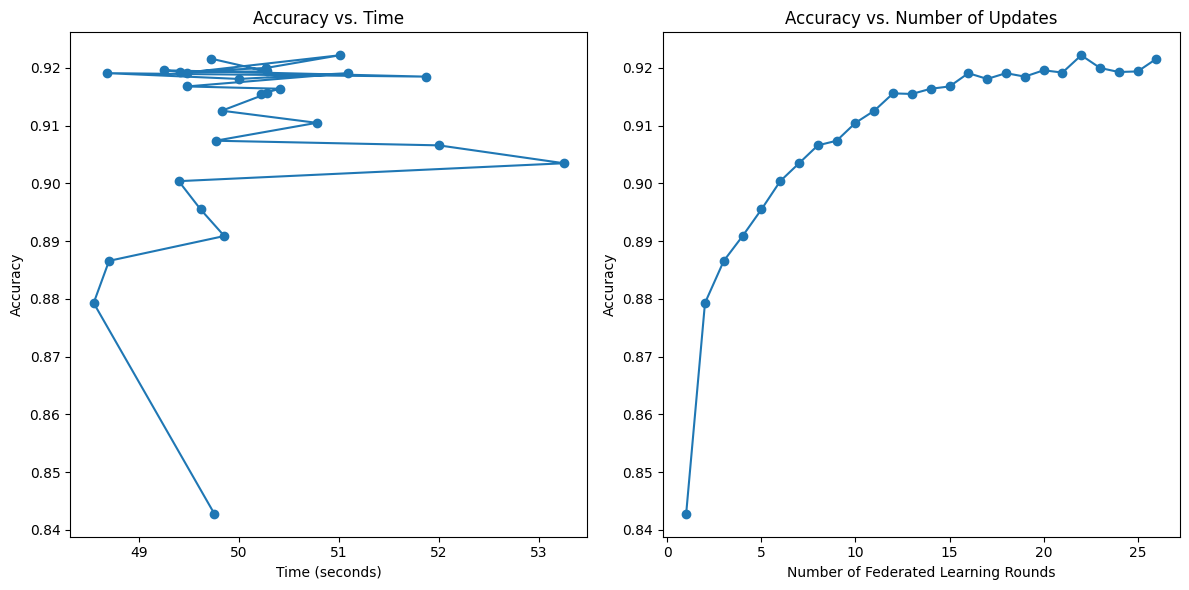

In [ ]:
# Plot Accuracy vs. Time
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(times, accuracies, marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Time')

# Plot Accuracy vs. Number of Updates
plt.subplot(1, 2, 2)
plt.plot(rounds, accuracies, marker='o')
plt.xlabel('Number of Federated Learning Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Updates')

plt.tight_layout()
plt.show()